# **Decision Tree Model Training**
---

**This notebook trains a basic decision tree classifier for breast cancer prediction. It begins by splitting the data into training and testing sets, ensuring balanced class distribution. The data is then scaled using MinMaxScaler.**

**A basic decision tree model is trained and evaluated, achieving reasonable precision and recall. Feature importance is analyzed, revealing that several features have zero importance. Instead of discarding these features, the notebook prepares the data for dimensionality reduction using PCA in a later step. The training and testing sets (including features with and without importance) are saved for subsequent processing.**


In [ ]:
# importing libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Splitting the dataset

path = r"E:\Machine learning\Machine Learning Project\Breast-Cancer-Prediction-with-Decision-Tree-Classifier\data\raw\breast-cancer-dataset.csv"
df = pd.read_csv(path)
df.drop('id',axis=1,inplace=True)
X = df.drop('diagnosis',axis=1)
Y = df['diagnosis']

# train test split
x_train,x_test,y_train,y_test = train_test_split(X,Y,
                                                 test_size=0.2,
                                                 random_state=42)

print(f"(x_train: {x_train.shape}, y_train: {y_train.shape})")
print(f"(x_test: {x_test.shape}, y_test: {y_test.shape})")

(x_train: (455, 30), y_train: (455,))
(x_test: (114, 30), y_test: (114,))


In [ ]:
# scaling down the dataset using MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train,y_train)

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


## **Class Distribution during train-test-split**

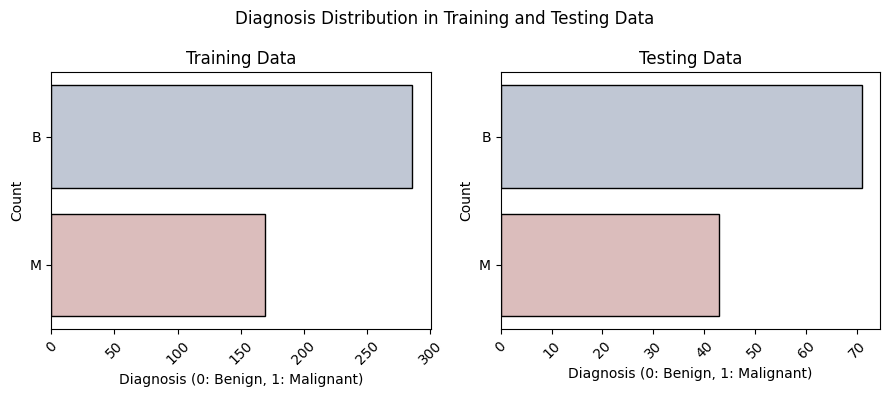

In [6]:
# Visualing distribution of class across the split

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

# Plot distribution of y_train
sns.countplot(y_train, ax=axes[0], palette="vlag", edgecolor="black")
axes[0].set_title("Training Data")
axes[0].set_xlabel("Diagnosis (0: Benign, 1: Malignant)")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# Plot distribution of y_test
sns.countplot(y_test, ax=axes[1], palette="vlag", edgecolor="black")
axes[1].set_title("Testing Data")
axes[1].set_xlabel("Diagnosis (0: Benign, 1: Malignant)")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)


fig.suptitle("Diagnosis Distribution in Training and Testing Data")
plt.tight_layout()
plt.show()

> **The above ensures that the distribution of the each class is balanced for training and testing.**

## **Building a basic model**

In [7]:
# building a basic model

clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(x_train,y_train)


y_pred = clf.predict(x_test)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           B       0.93      0.99      0.96        71
           M       0.97      0.88      0.93        43

    accuracy                           0.95       114
   macro avg       0.95      0.93      0.94       114
weighted avg       0.95      0.95      0.95       114



> **The precision/recall falling in the same range as of accuracy, suggesting that the model is also being cautious towards the minority class while making prediction.**

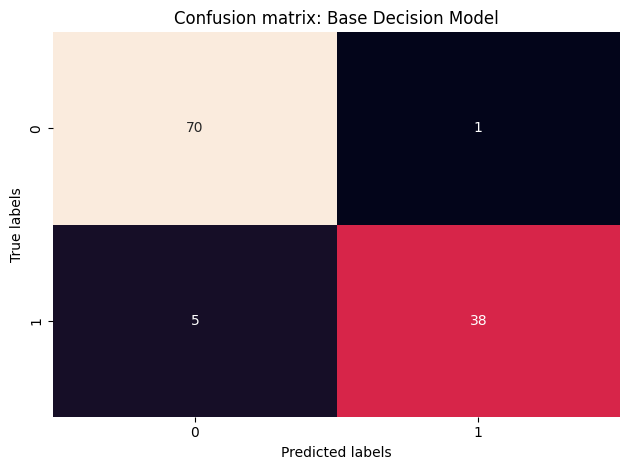

In [8]:
# plotting confusion matrix

sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt="d",cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion matrix: Base Decision Model')
plt.tight_layout()
plt.show()

## **Feature Importance**

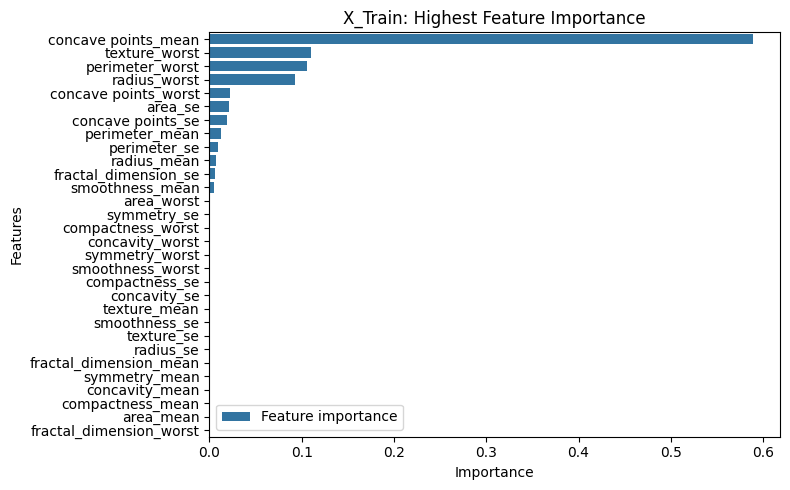

In [9]:
# Exploring Feature Importance

feature_imp = {'features':X.columns,
               'importance':clf.feature_importances_}

feature_imp_df = pd.DataFrame(feature_imp)
sorted_feature_imp= feature_imp_df.sort_values(by="importance", 
                                               ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=sorted_feature_imp, x="importance", y="features",
            label="Feature importance",legend=True)   
plt.title("X_Train: Highest Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [10]:
n_least_imp_features = len(feature_imp_df.query("importance <= 0"))
print(f"total features having 0 importance: {n_least_imp_features}")

total features having 0 importance: 18


> **Atmost, 18 features are not significantly impacting the model. Instead of removing them, we'll apply PCA to create new features with reduced dimensions, preserving relevant information.**

In [13]:
# labeling features with least/no importance i.e. feature_imp <= 0

least_imp_features = np.where(feature_imp_df['importance'] <= 0,
                              True,
                              False)

# shaping the x_train and x_test

x_train_least = x_train[:, np.argwhere(least_imp_features).flatten()]
x_test_least = x_test[:, np.argwhere(least_imp_features).flatten()]

x_train_most = x_train[:, np.argwhere(~least_imp_features).flatten()]
x_test_most = x_test[:, np.argwhere(~least_imp_features).flatten()]

# configuration
print("----no importance features configuration:----")
print(f"{x_train_least.shape=}")
print(f"{x_test_least.shape=}")

print("----importance features configuration:----")
print(f"{x_train_most.shape=}")
print(f"{x_test_most.shape=}")


----no importance features configuration:----
x_train_least.shape=(455, 18)
x_test_least.shape=(114, 18)
----importance features configuration:----
x_train_most.shape=(455, 12)
x_test_most.shape=(114, 12)


## **Storing data**

In [60]:
# storing the training and testing dataset

import os 
import pickle

interim_dir = r"D:\Pragyan\Machine Learning Cancer prediction\breast-cancer-prediction\data\interim"
os.makedirs(interim_dir,exist_ok=True)

training_file = os.path.join(interim_dir,"training.pkl")
with open(training_file,'wb') as f:
    pickle.dump([x_train_most,y_train],f)

testing_file = os.path.join(interim_dir,"testing.pkl")
with open(testing_file,'wb') as f:
    pickle.dump([x_test_most,y_test],f)

least_imp_feature_data_file = os.path.join(interim_dir,"least_imp_features.pkl")
with open(least_imp_feature_data_file,'wb') as f:
    pickle.dump([x_train_least,x_test_least],f)